In [24]:
from utils import datasets, kl_cpd, models, metrics
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
experiments_name = 'explosion'
train_dataset, test_dataset = datasets.CPDDatasets(experiments_name=experiments_name).get_dataset_()

Equal sampling is impossible, do random sampling.


In [3]:
args = {}
args['wnd_dim'] = 4
args['RNN_hid_dim'] = 16
args['batch_size'] = 1
args['lr'] = 1e-4
args['weight_decay'] = 0.
args['grad_clip'] = 10
args['CRITIC_ITERS'] = 5
args['weight_clip'] = .1
args['lambda_ae'] = 0.1 #0.001
args['lambda_real'] = 10 #0.1
args['num_layers'] = 1
args['data_dim'] = 12288
args['emb_dim'] = 100

args['window_1'] = 4
args['window_2'] = 4

args['sqdist'] = 50

In [4]:
seed = 0
models.fix_seeds(seed)
experiments_name = ('explosion')
    
netG = models.NetG(args)
netD = models.NetD(args)

kl_cpd_model = models.KLCPDVideo(netG, netD, args, train_dataset=train_dataset, test_dataset=test_dataset)

Using cache found in /home/eromanenkova/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [7]:
logger = TensorBoardLogger(save_dir='logs/explosion', name='kl_cpd')
early_stop_callback = EarlyStopping(monitor="val_mmd2_real_D", stopping_threshold=1e-5, 
                                    verbose=True, mode="min", patience=5)



for param in kl_cpd_model.extractor.parameters():
    param.requires_grad = False

trainer = pl.Trainer(
    max_epochs=100,
    gpus='1',
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=args['grad_clip'],
    logger=logger,
    callbacks=early_stop_callback
)

trainer.fit(kl_cpd_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type       | Params
-----------------------------------------
0 | netG      | NetG       | 1.4 M 
1 | netD      | NetD       | 2.5 M 
2 | extractor | Sequential | 2.0 M 
-----------------------------------------
4.0 M     Trainable params
2.0 M     Non-trainable params
6.0 M     Total params
23.865    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

AssertionError: Caught AssertionError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/eromanenkova/kl_cpd_for_video/utils/datasets.py", line 157, in __getitem__
    video, _, _, _ = self.video_clips.get_clip(idx)
  File "/home/eromanenkova/anaconda3/lib/python3.7/site-packages/torchvision/datasets/video_utils.py", line 380, in get_clip
    video.shape, self.num_frames
AssertionError: torch.Size([17, 240, 320, 3]) x 16


In [18]:
threshold_number = 25
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

In [21]:
_, delay_list, fp_delay_list = metrics.evaluation_pipeline(kl_cpd_model, 
                                                           kl_cpd_model.val_dataloader(),  
                                                           threshold_list, 
                                                           device='cuda', 
                                                           model_type='klcpd',
                                                           verbose=False)    



100%|██████████| 1/1 [02:20<00:00, 140.28s/it]


NameError: name 'path_to_saves' is not defined

In [22]:
path_to_saves = ''
metrics.write_metrics_to_file(path_to_saves + 'result_metrics.txt', _, '')

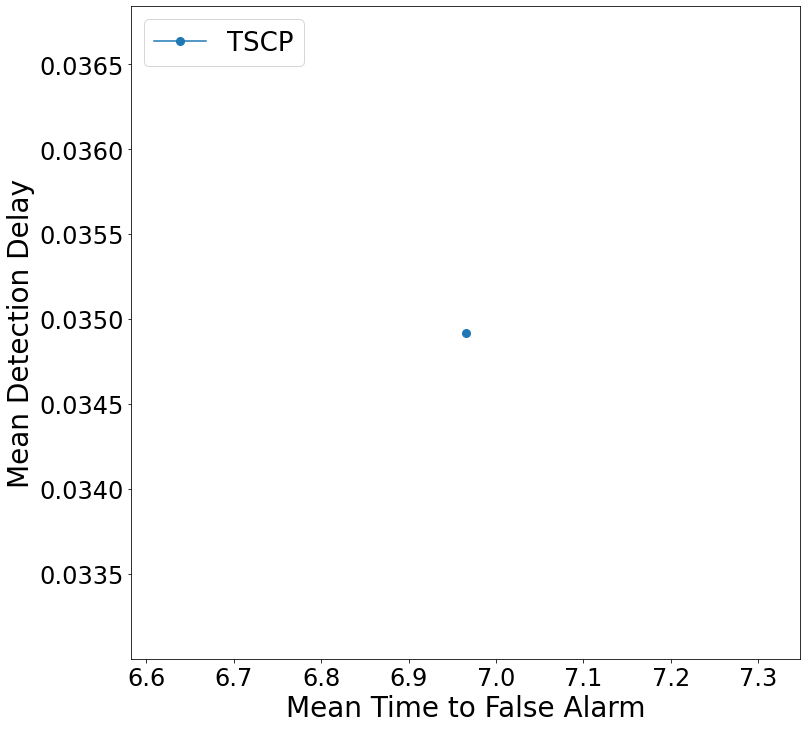

In [25]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list.values(), delay_list.values(), '-o', markersize=8, label='TSCP')
plt.xlabel('Mean Time to False Alarm', fontsize=28)
plt.ylabel('Mean Detection Delay', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=26);        
